#1. 라이브러리 임포트

In [ ]:
! pip install albumentations==0.4.6

In [88]:
import torch
print(torch.__version__)
import torchvision
print(torchvision.__version__)
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.ops import MultiScaleRoIAlign
from torchvision.models.detection import KeypointRCNN
import matplotlib.pyplot as plt
import gc
import cv2
import numpy as np
import os
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm.notebook import tqdm
from typing import Tuple, List, Sequence, Callable, Dict
from torch.utils.tensorboard import SummaryWriter #tensorboard
from sklearn.model_selection import train_test_split

1.8.0
0.9.0


In [5]:
import subprocess

def get_gpu_memory_map():
    """Get the current gpu usage.

    Returns
    -------
    usage: dict
        Keys are device ids as integers.
        Values are memory usage as integers in MB.
    """
    result = subprocess.check_output(
        [
            'nvidia-smi', '--query-gpu=memory.used',
            '--format=csv,nounits,noheader'
        ], encoding='utf-8')
    # Convert lines into a dictionary
    gpu_memory = [int(x) for x in result.strip().split('\n')]
    gpu_memory_map = dict(zip(range(len(gpu_memory)), gpu_memory))
    return gpu_memory_map

#gpu 메모리 확인
print(f'gpu 사용량 : {get_gpu_memory_map()}')

gpu 사용량 : {0: 320}


In [6]:
gc.collect()
torch.cuda.empty_cache()

In [7]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


# 2. 코랩 연결 부분

In [8]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

ModuleNotFoundError: No module named 'google.colab'

In [9]:
#root_dir = '/content/drive/MyDrive/'
root_dir = '/home/jngeun/motion_keypoint'

In [10]:
feature_extracting= False
num_classes = 48
learning_rate = 1e-4
batch_size = 4
num_epochs = 1000
test_dir = 'data/test_imgs'
train_dir = "data/train_imgs"
train_df_csv = "data/train_df.csv"
test_imgs = os.listdir(os.path.join(root_dir,test_dir))

# 3. 함수 정의 부분

In [11]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [12]:
class KeypointDataset(Dataset):
    def __init__(self, data_dir, label_path, phase, transforms):
        self.data_dir = data_dir
        self.df = pd.read_csv(label_path)
        self.transforms = transforms
        self.phase= phase
    def __len__(self) -> int:
        return self.df.shape[0]
    
    def __getitem__(self, index) -> Tuple[Tensor, Dict]:
        image_id = self.df.iloc[index, 0]
        labels = np.array([1])
        keypoints = self.df.iloc[index, 1:].values.reshape(-1, 2).astype(np.int64)

        x1, y1 = min(keypoints[:, 0]), min(keypoints[:, 1])
        x2, y2 = max(keypoints[:, 0]), max(keypoints[:, 1])
        boxes = np.array([[x1, y1, x2, y2]], dtype=np.int64)

        image = cv2.imread(os.path.join(self.data_dir, image_id), cv2.COLOR_BGR2RGB)

        targets ={
            'image': image,
            'bboxes': boxes,
            'labels': labels,
            'keypoints': keypoints
        }

        if self.transforms is not None:
          targets = self.transforms[self.phase](**targets)
        
        image = targets['image']
        image = image / 255.0

        targets = {
            'labels': torch.as_tensor(targets['labels'], dtype=torch.int64),
            'boxes': torch.as_tensor(targets['bboxes'], dtype=torch.float32),
            'keypoints': torch.as_tensor(
                np.concatenate([targets['keypoints'], np.ones((24, 1))], axis=1)[np.newaxis], dtype=torch.float32
            )
        }

        return image, targets

In [13]:
class TestDataset(Dataset):
    """__init__ and __len__ functions are the same as in TorchvisionDataset"""
    def __init__(self, data_dir, imgs, phase, transforms=None):
        self.data_dir = data_dir
        self.imgs = imgs
        self.phase = phase
        self.transforms = transforms

    def __getitem__(self, idx):
        filename = self.imgs[idx]
        # Read an image with OpenCV
        img = cv2.imread(os.path.join(self.data_dir, self.imgs[idx]))

        if self.transforms:
            augmented = self.transforms[self.phase](image=img)
            img = augmented['image']

        img = img / 255.0
        return filename, img
    
    def __len__(self):
        return len(self.imgs)
  


In [14]:
def get_model() -> nn.Module:
    backbone = resnet_fpn_backbone('resnet101', pretrained=True)
    roi_pooler = MultiScaleRoIAlign(
        featmap_names=['0', '1', '2', '3'],
        output_size=7,
        sampling_ratio=2
    )

    keypoint_roi_pooler = MultiScaleRoIAlign(
        featmap_names=['0', '1', '2', '3'],
        output_size=14,
        sampling_ratio=2
    )

    model = KeypointRCNN(
        backbone, 
        num_classes=2,
        num_keypoints=24,
        box_roi_pool=roi_pooler,
        keypoint_roi_pool=keypoint_roi_pooler
    )

    return model

In [15]:
def set_parameter_requires_grad(model,feature_extracting):
  if feature_extracting:
    for param in model.backbone.parameters():
      param.requires_grad = False
      # False로 바뀐 부분을 학습 안하겠다.


## checkout augmented image

In [106]:
def draw_keypoints(
    image: np.ndarray,
    keypoints: np.ndarray,
    edges: List[Tuple[int, int]] = None,
    keypoint_names: Dict[int, str] = None, 
    boxes: bool = True
) -> np.ndarray:
    """
    Args:
        image (ndarray): [H, W, C]
        keypoints (ndarray): [N, 3]
        edges (List(Tuple(int, int))): 
    """
    np.random.seed(42)
    colors = {k: tuple(map(int, np.random.randint(0, 255, 3))) for k in range(24)}

    if boxes:
        x1, y1 = min(keypoints[:, 0]), min(keypoints[:, 1])
        x2, y2 = max(keypoints[:, 0]), max(keypoints[:, 1])
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 100, 91), thickness=3)

    for i, keypoint in enumerate(keypoints):
        cv2.circle(
            image, 
            tuple(keypoint), 
            3, colors.get(i), thickness=1, lineType=cv2.FILLED)

        if keypoint_names is not None:
            cv2.putText(
                image, 
                f'{i}: {keypoint_names[i]}', 
                tuple(keypoint), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

    if edges is not None:
        for i, edge in enumerate(edges):
            cv2.line(
                image, 
                tuple(keypoints[edge[0]]), 
                tuple(keypoints[edge[1]]),
                colors.get(edge[0]), 1, lineType=cv2.LINE_AA)
    return image
    

In [76]:
def checkout_image(idx : int):
    img, targets = train_data.__getitem__(idx)
    
    img = np.array(img)
    keypoints = np.array(targets['keypoints'][:,:,:2]).reshape(-1, 2)
    keypoints = keypoints.astype(np.int64)
    
    keypoint_names = {
        0: 'nose',
        1: 'left_eye',
        2: 'right_eye',
        3: 'left_ear', 
        4: 'right_ear', 
        5: 'left_shoulder', 
        6: 'right_shoulder',
        7: 'left_elbow', 
        8: 'right_elbow',
        9: 'left_wrist', 
        10: 'right_wrist',
        11: 'left_hip', 
        12: 'right_hip',
        13: 'left_knee', 
        14: 'right_knee',
        15: 'left_ankle', 
        16: 'right_ankle',
        17: 'neck', 
        18: 'left_palm', 
        19: 'right_palm', 
        20: 'spine2(back)',
        21: 'spine1(waist)', 
        22: 'left_instep',
        23: 'right_instep'
    }

    edges = [
        (0, 1), (0, 2), (2, 4), (1, 3), (6, 8), (8, 10), (9, 18),
        (10, 19), (5, 7), (7, 9), (11, 13), (13, 15), (12, 14),
        (14, 16), (15, 22), (16, 23), (20, 21), (5, 6), (5, 11),
        (6, 12), (11, 12), (17, 20), (20, 21), 
    ]
    img = np.transpose(img,(1,2,0))
    img =  draw_keypoints(img, keypoints,edges, keypoint_names, boxes=False)
  
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


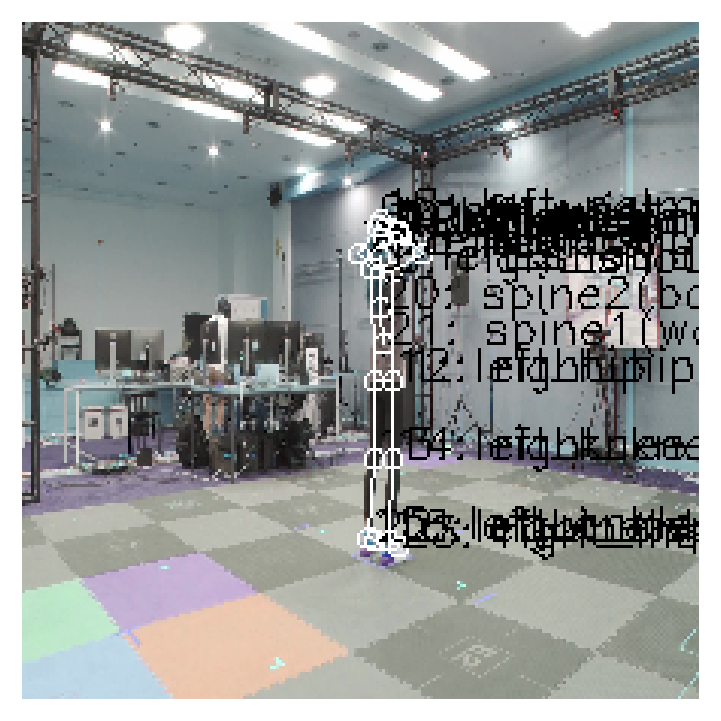

In [77]:
pred_img = checkout_image(0)
fig, ax = plt.subplots(dpi=224)
ax.imshow(pred_img)   
ax.axis('off')
plt.show()

## Local Contrast Normalization
이론링크 : https://deepestdocs.readthedocs.io/en/latest/003_image_processing/0030/  
코드링크 : https://github.com/dibyadas/Visualize-Normalizations/blob/master/LocalContrastNorm.ipynb

In [112]:
img, targets = train_data.__getitem__(100)
image_tensor = torch.tensor([np.array(img)])
image_tensor.shape

torch.Size([1, 3, 224, 224])

In [113]:
def gaussian_filter(kernel_shape):
    x = np.zeros(kernel_shape, dtype='float32')
 
    def gauss(x, y, sigma=2.0):
        Z = 2 * np.pi * sigma ** 2
        return  1. / Z * np.exp(-(x ** 2 + y ** 2) / (2. * sigma ** 2))
 
    mid = np.floor(kernel_shape[-1] / 2.)
    for kernel_idx in range(0, kernel_shape[1]):
        for i in range(0, kernel_shape[2]):
            for j in range(0, kernel_shape[3]):
                x[0, kernel_idx, i, j] = gauss(i - mid, j - mid)
 
    return x / np.sum(x)

In [114]:
def LocalContrastNorm(image,radius=9):
    """
    image: torch.Tensor , .shape => (1,channels,height,width) 
    
    radius: Gaussian filter size (int), odd
    """
    if radius%2 == 0:
        radius += 1
    def get_gaussian_filter(kernel_shape):
        x = np.zeros(kernel_shape, dtype='float64')
 
        def gauss(x, y, sigma=2.0):
            Z = 2 * np.pi * sigma ** 2
            return  1. / Z * np.exp(-(x ** 2 + y ** 2) / (2. * sigma ** 2))
 
        mid = np.floor(kernel_shape[-1] / 2.)
        for kernel_idx in range(0, kernel_shape[1]):
            for i in range(0, kernel_shape[2]):
                for j in range(0, kernel_shape[3]):
                    x[0, kernel_idx, i, j] = gauss(i - mid, j - mid)
 
        return x / np.sum(x)
    
    n,c,h,w = image.shape[0],image.shape[1],image.shape[2],image.shape[3]

    gaussian_filter = torch.Tensor(get_gaussian_filter((1,c,radius,radius)))
    filtered_out = F.conv2d(image,gaussian_filter,padding=radius-1)
    mid = int(np.floor(gaussian_filter.shape[2] / 2.))
    ### Subtractive Normalization
    centered_image = image - filtered_out[:,:,mid:-mid,mid:-mid]
    
    ## Variance Calc
    sum_sqr_image = F.conv2d(centered_image.pow(2),gaussian_filter,padding=radius-1)
    s_deviation = sum_sqr_image[:,:,mid:-mid,mid:-mid].sqrt()
    per_img_mean = denom.mean()
    
    ## Divisive Normalization
    divisor = np.maximum(per_img_mean.numpy(),s_deviation.numpy())
    divisor = np.maximum(divisor, 1e-4)
    new_image = centered_image / torch.Tensor(divisor)
    return new_image



In [115]:
gfilter = torch.Tensor(gaussian_filter((1,3,9,9)))
filtered = F.conv2d(image_tensor,gfilter,padding=8) ## padding = 8 = 9-1 (radius - 1 ) for border == 'full'
mid = int(np.floor(gfilter.shape[2] / 2.))
sum_sqr_XX = F.conv2d(centered_image.pow(2),gfilter,padding=8)
denom = sum_sqr_XX[:,:,mid:-mid,mid:-mid].sqrt()

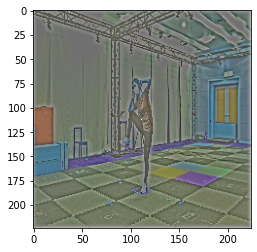

In [116]:
ret = LocalContrastNorm(image_tensor,radius=9)
ret = ret[0].numpy().transpose((1,2,0))
scaled_ret = (ret - ret.min())/(ret.max() - ret.min())
plt.imshow(scaled_ret)

In [68]:
# augmentation 
A_transforms = {
    'train':
        A.Compose([
            A.Resize(224, 224, always_apply=True),
            A.Rotate(limit=40,p=0),
            A.OneOf([A.HorizontalFlip(p=1),
                     A.RandomRotate90(p=1),
                     A.VerticalFlip(p=1)            
            ], p=0),
            A.OneOf([A.MotionBlur(p=1),
                     A.GaussNoise(p=1)                 
            ], p=0),
            #A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2()
        ],  bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']),
            keypoint_params=A.KeypointParams(format='xy')) ,
    
    'val':
        A.Compose([
            A.Resize(224, 224, always_apply=True),
            #A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']),
            keypoint_params=A.KeypointParams(format='xy')),
    
    'test':
        A.Compose([
            A.Resize(224, 224, always_apply=True),
          
          #  A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2()
        ])
}

In [69]:
#train, validation 나누기
train_data = KeypointDataset(data_dir = os.path.join(root_dir,train_dir),label_path = 
                          os.path.join(root_dir,train_df_csv) ,transforms=A_transforms,phase="train")
train_loader = DataLoader(dataset=train_data,batch_size=batch_size,shuffle=True,num_workers=2, collate_fn=collate_fn)
    
test_data = TestDataset(os.path.join(root_dir,test_dir), test_imgs,transforms=A_transforms,  phase='test')
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# 4. 모델 초기화

In [29]:
model = get_model()
model.cuda()
set_parameter_requires_grad(model,feature_extracting)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
#optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=5e-4)
#patience만큼 loss가 향상되지 않으면 learning_rate에 factor을 곱해줌 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.1, patience = 5, verbose=True)
writer = SummaryWriter()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /home/jngeun/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth
13.8%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

40.0%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

66.2%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.i

In [31]:
#gpu 메모리 확인
print(get_gpu_memory_map())

{0: 1468}


## 4.1 모델 로드

In [16]:
# 4.1 model load


# 5. train / save

In [32]:
min_loss = 9999

for epoch in range(num_epochs):
    model.train()
    losses = []
    loop = tqdm(train_loader)
    for i, (images, targets) in enumerate(loop):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        optimizer.zero_grad()
        #loss = criterion(model(images), targets)
        loss = model(images,targets)['loss_keypoint']
        losses.append(loss)
        loss.backward()
        optimizer.step()
        
    mean_loss = sum(losses) / len(losses)
    lr = optimizer.param_groups[0]['lr']
    scheduler.step(mean_loss)
    writer.add_scalar("Loss/train", mean_loss, epoch)
    writer.add_scalar("learning_rate", lr, epoch)
    print(f'| epoch: {epoch} | loss: {mean_loss:.4f} | lr : {lr}')
    print()
        
    if mean_loss < min_loss:
      min_loss = mean_loss
      torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': loss}
              ,os.path.join(root_dir,'model/best_model.pt'))
        
writer.flush()

  0%|          | 0/1049 [00:00<?, ?it/s]

KeyboardInterrupt: 

## tensorboard

In [17]:
writer.close()

In [ ]:
!tensorboard --logdir=runs

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.4.0 at http://localhost:6007/ (Press CTRL+C to quit)


# 6. test

In [ ]:
#추론
model.eval()
all_predictions = []
files = []
with torch.no_grad():
  loop = tqdm(test_loader)
  for filenames, inputs in loop:
    pred = model(inputs.to(device))
    # x means pred[0],pred[1],-----,pred[batch]
    predictions = [x['keypoints'][0][:,:2].reshape(-1).detach().cpu().numpy() for x in pred]
    files.extend(filenames)
    for prediction in predictions:
      all_predictions.append(prediction)

# 7. 파일 저장

In [ ]:
all_predictions = np.array(all_predictions)
for i in range(all_predictions.shape[0]):
    all_predictions[i, [2*j for j in range(num_classes//2)]] /= 300 / 1920
    all_predictions[i, [2*j + 1 for j in range(num_classes//2)]] /= 150 / 1080
df_sub = pd.read_csv(os.path.join(root_dir,'data/sample_submission.csv'))
df = pd.DataFrame(columns=df_sub.columns)
df['image'] = files
df.iloc[:, 1:] = all_predictions
df.head()

In [ ]:
from datetime import datetime
now = datetime.now()
timeday = str(now)[5:10]
df.to_csv(os.path.join(root_dir,f'data/submission_{timeday}.csv'), index=False)

In [ ]:
# train 데이터 확인
train_image , target = train_data.__getitem__(0)
np.array(train_image).shape
target_array = np.array(target['keypoints'][0][:,:2])
plt.imshow(np.array(train_image).transpose(1,2,0))

In [ ]:
#test 확인
filename, test_img = test_data.__getitem__(0)
plt.imshow(np.array(test_img).transpose(1,2,0))

In [ ]:
# def draw_keypoints(
#     image: np.ndarray,
#     keypoints: np.ndarray,
#     edges: List[Tuple[int, int]] = None,
#     keypoint_names: Dict[int, str] = None, 
#     boxes: bool = True,
#     dpi: int = 200
# ) -> None:
#     """
#     Args:
#         image (ndarray): [H, W, C]
#         keypoints (ndarray): [N, 3]
#         edges (List(Tuple(int, int))): 
#     """
#     np.random.seed(42)
#     colors = {k: tuple(map(int, np.random.randint(0, 255, 3))) for k in range(24)}

#     if boxes:
#         x1, y1 = min(keypoints[:, 0]), min(keypoints[:, 1])
#         x2, y2 = max(keypoints[:, 0]), max(keypoints[:, 1])
#         cv2.rectangle(image, (x1, y1), (x2, y2), (255, 100, 91), thickness=3)

#     for i, keypoint in enumerate(keypoints):
#         cv2.circle(
#             image, 
#             tuple(keypoint), 
#             3,(255,0,0), thickness=3, lineType=cv2.FILLED)

#         if keypoint_names is not None:
#             cv2.putText(
#                 image, 
#                 f'{i}: {keypoint_names[i]}', 
#                 tuple(keypoint), 
#                 cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

#     if edges is not None:
#         for i, edge in enumerate(edges):
#             cv2.line(
#                 image, 
#                 tuple(keypoints[edge[0]]), 
#                 tuple(keypoints[edge[1]]),
#                 colors.get(edge[0]), 3, lineType=cv2.LINE_AA)

#     fig, ax = plt.subplots(dpi=dpi)
#     ax.imshow(image)
#     ax.axis('off')
#     plt.show()
#     keypoints = target_array
# keypoint_names = {
#     0: 'nose',
#     1: 'left_eye',
#     2: 'right_eye',
#     3: 'left_ear', 
#     4: 'right_ear', 
#     5: 'left_shoulder', 
#     6: 'right_shoulder',
#     7: 'left_elbow', 
#     8: 'right_elbow',
#     9: 'left_wrist', 
#     10: 'right_wrist',
#     11: 'left_hip', 
#     12: 'right_hip',
#     13: 'left_knee', 
#     14: 'right_knee',
#     15: 'left_ankle', 
#     16: 'right_ankle',
#     17: 'neck', 
#     18: 'left_palm', 
#     19: 'right_palm', 
#     20: 'spine2(back)',
#     21: 'spine1(waist)', 
#     22: 'left_instep',
#     23: 'right_instep'
# }

# edges = [
#     (0, 1), (0, 2), (2, 4), (1, 3), (6, 8), (8, 10), (9, 18),
#     (10, 19), (5, 7), (7, 9), (11, 13), (13, 15), (12, 14),
#     (14, 16), (15, 22), (16, 23), (20, 21), (5, 6), (5, 11),
#     (6, 12), (11, 12), (17, 20), (20, 21), 
# ]
# draw_keypoints(np.array(train_image).transpose(1,2,0), keypoints, edges, keypoint_names, boxes=False, dpi=400)